In [1]:
# Import libraries
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json, os, glob

## MODELS

In [2]:
def Model_1(data, OBJ_FUNC=1):
    model = gp.Model("model1")
    
    #unpack data
    Blocks = data["Blocks"]
    Sessions = data["Sessions"]
    Sessions_blocks = data["Sessions_b"]
    Interpreters = data["Interpreters"]
    Languages = data["Languages"]
    Languages_sessions = data["Languages_s"]
    Languages_interpreters = data["Languages_i"]

    #Generate the pairwise combinations of languages
    Pairwise_languages_sessions = Languages_sessions.copy()
    for s in Sessions:
        Pairwise_languages_sessions[s] = [(l1, l2) for i, l1 in enumerate(Languages_sessions[s]) 
                                          for l2 in Languages_sessions[s][i+1:]]

    # Create variables
    #x[b, s, language, interpreter] = 1 if block b is assigned to session s with language l and interpreter i
    assign = {}
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for l in Pairwise_languages_sessions[s]:
                for i in Interpreters:
                    assign[b, s, l, i] = model.addVar(vtype=GRB.BINARY, name=f"x_{b}_{s}_{l}_{i}")

    session_covered = {}
    for s in Sessions:
        #session_covered[s] = 1 if session s is covered by at least one interpreter
        session_covered[s] = model.addVar(vtype=GRB.BINARY, name=f"session_covered_{s}")
    
    # Add constraints
    #Interpreter must speak the language
    for b in Blocks:
        for s in Sessions_blocks[b]:
            #change by pairwise language
            for l in Pairwise_languages_sessions[s]:
                l1, l2 = l
                for i in Interpreters:
                    if l1 not in Languages_interpreters[i] or l2 not in Languages_interpreters[i]:
                        model.addConstr(assign[b, s, l, i] == 0, name=f"lang_{b}_{s}_{l}_{i}")
    
    #One interpreter can translate only one session at a time
    for b in Blocks:
        for i in Interpreters:
            model.addConstr(gp.quicksum(assign[b, s, l, i] for s in Sessions_blocks[b] for l in Pairwise_languages_sessions[s]) <= 1, 
                            name=f"interpreter_{b}_{i}")
    
    # Each session can have only one interpreter per language
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for l in Pairwise_languages_sessions[s]:
                model.addConstr(gp.quicksum(assign[b, s, l, i] for i in Interpreters) <= 1, 
                                name=f"session_{s}_{l}")
            
    #Session covered if all languages are covered
    for b in Blocks:
        for s in Sessions_blocks[b]:
            model.addConstr(session_covered[s] <= gp.quicksum(assign[b, s, l, i]
                                                            for l in Pairwise_languages_sessions[s]
                                                            for i in Interpreters) / len(Pairwise_languages_sessions[s]), 
                                                            name=f"session_covered_{s}")
                            
    

    # Set objective
    #Maximize the number of languages translated
    #OBJ1
    if OBJ_FUNC == 1:
        model.setObjective(gp.quicksum(assign[b, s, l, i] for b in Blocks for s in Sessions_blocks[b] 
                                        for l in Pairwise_languages_sessions[s] for i in Interpreters), GRB.MAXIMIZE)
    #
    #Max the number of sessions translated
    if OBJ_FUNC == 2:
        model.setObjective(gp.quicksum(session_covered[s] for b in Blocks for s in Sessions_blocks[b]), GRB.MAXIMIZE)
    
    return model

In [3]:
def Model_2(data, OBJ_FUNC=1):
    model = gp.Model("model2")
    
    
    #unpack data
    Blocks = data["Blocks"]
    Sessions = data["Sessions"]
    Sessions_blocks = data["Sessions_b"]
    Interpreters = data["Interpreters"]
    Languages = data["Languages"]
    Languages_sessions = data["Languages_s"]
    Languages_interpreters = data["Languages_i"]

    #Generate the pairwise combinations of languages
    Pairwise_languages_sessions = Languages_sessions.copy()
    for s in Sessions:
        Pairwise_languages_sessions[s] = [(l1, l2) for i, l1 in enumerate(Languages_sessions[s]) 
                                          for l2 in Languages_sessions[s][i+1:]]

    # Create variables
    #x[b, s, language, interpreter] = 1 if block b is assigned to session s with language l and interpreter i
    assign = {}
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for l in Pairwise_languages_sessions[s]:
                for i in Interpreters:
                    assign[b, s, l, i] = model.addVar(vtype=GRB.BINARY, name=f"x_{b}_{s}_{l}_{i}")

    session_covered = {}
    for s in Sessions:
        #session_covered[s] = 1 if session s is covered by at least one interpreter
        session_covered[s] = model.addVar(vtype=GRB.BINARY, name=f"session_covered_{s}")
    
    # Add constraints
    #Interpreter must speak the language
    for b in Blocks:
        for s in Sessions_blocks[b]:
            #change by pairwise language
            for l in Pairwise_languages_sessions[s]:
                l1, l2 = l
                for i in Interpreters:
                    if l1 not in Languages_interpreters[i] or l2 not in Languages_interpreters[i]:
                        model.addConstr(assign[b, s, l, i] == 0, name=f"lang_{b}_{s}_{l}_{i}")
    
    #One interpreter can translate only one session at a time
    for b in Blocks:
        for i in Interpreters:
            model.addConstr(gp.quicksum(assign[b, s, l, i] for s in Sessions_blocks[b] for l in Pairwise_languages_sessions[s]) <= 1, 
                            name=f"interpreter_{b}_{i}")
    
    # Each session can have only one interpreter per language
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for l in Pairwise_languages_sessions[s]:
                model.addConstr(gp.quicksum(assign[b, s, l, i] for i in Interpreters) <= 1, 
                                name=f"session_{s}_{l}")
                
    #Session covered if all languages are covered
    for b in Blocks:
        for s in Sessions_blocks[b]:
            model.addConstr(session_covered[s] <= gp.quicksum(assign[b, s, l, i]
                                                            for l in Pairwise_languages_sessions[s]
                                                            for i in Interpreters) / len(Pairwise_languages_sessions[s]), 
                                                            name=f"session_covered_{s}")
            
    #Max 15 hours per interpreter
    for i in Interpreters:
        model.addConstr(gp.quicksum(assign[b, s, l, i] for b in Blocks for s in Sessions_blocks[b] 
                                    for l in Pairwise_languages_sessions[s]) <= 15, 
                        name=f"max_hours_{i}")
    
    # Max 3 sessions in a row per interpreter
    for i in Interpreters:
        for j in range(len(Sessions_blocks) - 3):
                model.addConstr(gp.quicksum(assign[b, s, l, i] for b in Blocks[j:j+4] for s in Sessions_blocks[b] for l in Pairwise_languages_sessions[s]) <= 3, 
                                name=f"max_sessions_{b}_{s}_{i}")

    # Set objective
    #Maximize the number of languages translated
    #OBJ1
    if OBJ_FUNC == 1:
        model.setObjective(gp.quicksum(assign[b, s, l, i] for b in Blocks for s in Sessions_blocks[b] 
                                        for l in Pairwise_languages_sessions[s] for i in Interpreters), GRB.MAXIMIZE)
    #
    #Max the number of sessions translated
    if OBJ_FUNC == 2:
        model.setObjective(gp.quicksum(session_covered[s] for b in Blocks for s in Sessions_blocks[b]), GRB.MAXIMIZE)
    
    return model

In [4]:
def Model_3(data, OBJ_FUNC=1):
    #Bridge implementation
    model = gp.Model("model with bridge")
    
    
    #unpack data
    Blocks = data["Blocks"]
    Sessions = data["Sessions"]
    Sessions_blocks = data["Sessions_b"]
    Interpreters = data["Interpreters"]
    Languages = data["Languages"]
    Languages_sessions = data["Languages_s"]
    Languages_interpreters = data["Languages_i"]

    #Generate the pairwise combinations of languages
    Pairwise_languages_sessions = Languages_sessions.copy()
    for s in Sessions:
        Pairwise_languages_sessions[s] = [(l1, l2) for i, l1 in enumerate(Languages_sessions[s]) 
                                          for l2 in Languages_sessions[s][i+1:]]

    #Pairwise_languages = Languages.copy()
    Pairwise_languages = [(l1, l2) for i, l1 in enumerate(Languages) 
                                          for l2 in Languages[i+1:]]

    # Create variables
    #x[b, s, language, interpreter] = 1 if block b is assigned to session s with language l and interpreter i
    assign = {}
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for l in Pairwise_languages:
                for i in Interpreters:
                    assign[b, s, l, i] = model.addVar(vtype=GRB.BINARY, name=f"x_{b}_{s}_{l}_{i}")

    #language pair covered
    cover_language_pair = {}
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for l in Pairwise_languages_sessions[s]:
                cover_language_pair[b, s, l] = model.addVar(vtype=GRB.BINARY, name=f"cover_language_pair_{b}_{s}_{l}")
                
    #bridge variables
    bridge = {}
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for l in Pairwise_languages_sessions[s]:
                for i1 in Interpreters:
                    for i2 in Interpreters:
                        if i1 != i2:
                            for l_p in Languages_interpreters[i1]:
                                if (l_p in Languages_interpreters[i2] and l_p not in l):
                                    bridge[b, s, l, i1, i2, l_p] = model.addVar(vtype=GRB.BINARY, name=f"bridge_{b}_{s}_{l}_{i1}_{i2}_{l_p}")

    session_covered = {}
    for s in Sessions:
        #session_covered[s] = 1 if session s is covered by at least one interpreter
        session_covered[s] = model.addVar(vtype=GRB.BINARY, name=f"session_covered_{s}")
    
    # Add constraints

    #bridge if they have one language in common
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for l in Pairwise_languages_sessions[s]:
                for i1 in Interpreters:
                    for i2 in Interpreters:
                        if i1 != i2:
                            if l[0] not in Languages_interpreters[i1] or not l[1] in Languages_interpreters[i2]:
                                for l_p in Languages_interpreters[i1]:
                                    if (l_p in Languages_interpreters[i2] and l_p not in l):
                                        model.addConstr(bridge[b, s, l, i1, i2, l_p] ==0, name=f"bridge_{b}_{s}_{l}_{i1}_{i2}")
                            #if they have one language in common
                            else:
                                for l_p in Languages_interpreters[i1]:
                                    if (l_p in Languages_interpreters[i2] and l_p not in l):
                                        if Languages.index(l_p) < Languages.index(l[0]):
                                            model.addConstr(bridge[b, s, l, i1, i2, l_p] <= assign[b, s, (l_p, l[0]), i1],
                                                            name=f"bridge_{b}_{s}_{l}_{i1}_{i2}_{l_p}")
                                            model.addConstr(bridge[b, s, l, i1, i2, l_p] <= assign[b, s, (l_p, l[1]), i2],
                                                            name=f"bridge_{b}_{s}_{l}_{i1}_{i2}_{l_p}")
                                        
                                        elif(Languages.index(l_p) < Languages.index(l[1])):
                                            model.addConstr(bridge[b, s, l, i1, i2, l_p] <= assign[b, s, (l[0], l_p), i1],
                                                            name=f"bridge_{b}_{s}_{l}_{i1}_{i2}_{l_p}")
                                            model.addConstr(bridge[b, s, l, i1, i2, l_p] <= assign[b, s, (l_p, l[1]), i2],
                                                            name=f"bridge_{b}_{s}_{l}_{i1}_{i2}_{l_p}")
                                        else:
                                            model.addConstr(bridge[b, s, l, i1, i2, l_p] <= assign[b, s, (l[0], l_p), i1],
                                                            name=f"bridge_{b}_{s}_{l}_{i1}_{i2}_{l_p}")
                                            model.addConstr(bridge[b, s, l, i1, i2, l_p] <= assign[b, s, (l[1], l_p), i2],
                                                            name=f"bridge_{b}_{s}_{l}_{i1}_{i2}_{l_p}")
                                                          
    #Interpreter only does one bridge                                
    for b in Blocks:
        for s in Sessions_blocks[b]:
            #change by pairwise language
                for i1 in Interpreters:
                        model.addConstr(gp.quicksum(bridge[b, s, l, i1, i2, l_p] for i2 in Interpreters if i1 != i2 for l in Pairwise_languages_sessions[s] for l_p in Languages_interpreters[i1] if (l_p in Languages_interpreters[i2] and l_p not in l)) <= 1, 
                                        name=f"bridge_{b}_{s}_{i1}_{i2}")
    
    #Interpreter must speak the language          
    for b in Blocks:
        for s in Sessions_blocks[b]:
            #change by pairwise language
            for l in Pairwise_languages:
                l1, l2 = l
                for i in Interpreters:
                    if l1 not in Languages_interpreters[i] or l2 not in Languages_interpreters[i]:
                        model.addConstr(assign[b, s, l, i] == 0, name=f"lang_{b}_{s}_{l}_{i}")
    
    #One interpreter can translate only one session at a time
    for b in Blocks:
        for i in Interpreters:
            model.addConstr(gp.quicksum(assign[b, s, l, i] for s in Sessions_blocks[b] for l in Pairwise_languages) <= 1, 
                            name=f"interpreters_{b}_{i}")
    
    # Each session can have only one interpreter per language
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for l in Pairwise_languages:
                model.addConstr(gp.quicksum(assign[b, s, l, i] for i in Interpreters) <= 1, 
                                name=f"session_{s}_{l}")
                
    #Session covered if all languages are covered
    for b in Blocks:
        for s in Sessions_blocks[b]:
            model.addConstr(session_covered[s] <= gp.quicksum(cover_language_pair[b, s, l]
                                                            for l in Pairwise_languages_sessions[s])
                                                            / len(Pairwise_languages_sessions[s]), 
                                                            name=f"session_covered_{s}")
            
    #Max 15 hours per interpreter
    for i in Interpreters:
        model.addConstr(gp.quicksum(assign[b, s, l, i] for b in Blocks for s in Sessions_blocks[b] 
                                    for l in Pairwise_languages_sessions[s]) <= 15, 
                        name=f"max_hours_{i}")
    
    # Max 3 sessions in a row per interpreter
    for i in Interpreters:
        for j in range(len(Sessions_blocks) - 3):
                model.addConstr(gp.quicksum(assign[b, s, l, i] for b in Blocks[j:j+4] for s in Sessions_blocks[b] for l in Pairwise_languages_sessions[s]) <= 3, 
                                name=f"max_sessions_{Blocks[j]}_{s}_{i}")
                

    #language pair covered if at one interpreter is assigned to it or there is a bridge
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for l in Pairwise_languages_sessions[s]:
                model.addConstr(cover_language_pair[b, s, l] <= (gp.quicksum(assign[b, s, l, i] for i in Interpreters)) + (gp.quicksum(bridge[b, s, l, i1, i2, l_p] for i1 in Interpreters for i2 in Interpreters if i1 != i2 for l_p in Languages_interpreters[i1] if (l_p in Languages_interpreters[i2] and l_p not in l))),  
                                name=f"cover_language_pair_{b}_{s}_{l}")

    # Set objective
    #Maximize the number of languages translated
    #OBJ1
    if OBJ_FUNC == 1:
        model.setObjective(gp.quicksum(cover_language_pair[b, s, l]
                                      for b in Blocks for s in Sessions_blocks[b]       
                                        for l in Pairwise_languages_sessions[s]), GRB.MAXIMIZE)
    #
    #Max the number of sessions translated
    if OBJ_FUNC == 2:
        model.setObjective(gp.quicksum(session_covered[s] for b in Blocks for s in Sessions_blocks[b]) , GRB.MAXIMIZE)
    
    return model

## PLOTS

In [ ]:
# ------------------------------------------------------------
# 0) Where are your JSON instances?
# ------------------------------------------------------------
#INST_DIR = r"simplie_instances"
INST_DIR = r"instances"
instance_files = sorted(glob.glob(os.path.join(INST_DIR, "*.json")))

# ------------------------------------------------------------
# 1) Map a model-name to the *function* that builds it
# ------------------------------------------------------------
model_builders = {
    "Basic"      : Model_1,     # def Model(...)
    "Operational": Model_2,   # def Model_2(...)
    "Bridging"   : Model_3,   # def Model_3(...)
}

# ------------------------------------------------------------
# 2) Solve everything and fill `records`
# ------------------------------------------------------------
records = []   # this is what the plotting cell will consume

for f in instance_files:
    with open(f) as fp:
        data = json.load(fp)
    inst = os.path.splitext(os.path.basename(f))[0]   # e.g. "isp-S40-I30"

    print(f"+++++++++++++++ Starting instance {inst} with {len(model_builders)} models +++++++++++++++")
    for mname, build in model_builders.items():
        try:
            print(f"------------------- Starting instance {inst} with model {mname} -------------------")
            gp.setParam("OutputFlag", 0)  # suppress output

            print(f"Building model {mname} for instance {inst}...")
            m1 = build(data, OBJ_FUNC=1)
            m1.setParam(GRB.Param.TimeLimit, 1)

            print(f"Optimizing model {mname} for instance {inst}...")
            m1.optimize()
            of1 = m1.objVal
            runtime_1 = m1.Runtime
            mipgap_1 = m1.MIPGap

            m1.dispose()  # free resources
            print(f"Model {mname} for instance {inst} solved → OF1: {of1}, Runtime: {runtime_1}, MIPGap: {mipgap_1}")
            # --- objective 2 ----------------------------------------------------
            print(f"Building model {mname} for instance {inst} with objective 2...")
            m2 = build(data, OBJ_FUNC=2)
            m2.setParam(GRB.Param.TimeLimit, 1)

            print(f"Optimizing model {mname} for instance {inst} with objective 2...")
            m2.optimize()
            of2 = m2.objVal
            runtime_2 = m2.Runtime
            mipgap_2 = m2.MIPGap

            m2.dispose()  # free resources
            print(f"Model {mname} for instance {inst} with objective 2 solved → OF2: {of2}, Runtime: {runtime_2}, MIPGap: {mipgap_2}")
            # --- store ----------------------------------------------------------
            records.append({
                "instance": inst,
                "model"   : mname,
                "OF1"     : of1,
                "OF2"     : of2,
                "runtime_1": runtime_1,
                "runtime_2": runtime_2,
                "MIPgap_1": mipgap_1,
                "MIPgap_2": mipgap_2,
            })

            gp.disposeDefaultEnv()
            print(f"----------------------------------------------------------------------------\n")
        except:
            print(f"Error solving {inst} with model {mname}. Skipping...")
            continue
    print(f"+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")

+++++++++++++++ Starting instance example with 2 models +++++++++++++++
------------------- Starting instance example with model Basic -------------------
Set parameter Username
Set parameter LicenseID to value 2678447
Academic license - for non-commercial use only - expires 2026-06-16
Building model Basic for instance example...
Optimizing model Basic for instance example...
Model Basic for instance example solved → OF1: 2.0, Runtime: 0.0, MIPGap: 0.0
Building model Basic for instance example with objective 2...
Optimizing model Basic for instance example with objective 2...
Model Basic for instance example with objective 2 solved → OF2: 1.0, Runtime: 0.0, MIPGap: 0.0
----------------------------------------------------------------------------

------------------- Starting instance example with model Operational -------------------
Set parameter Username
Set parameter LicenseID to value 2678447
Academic license - for non-commercial use only - expires 2026-06-16
Building model Operatio

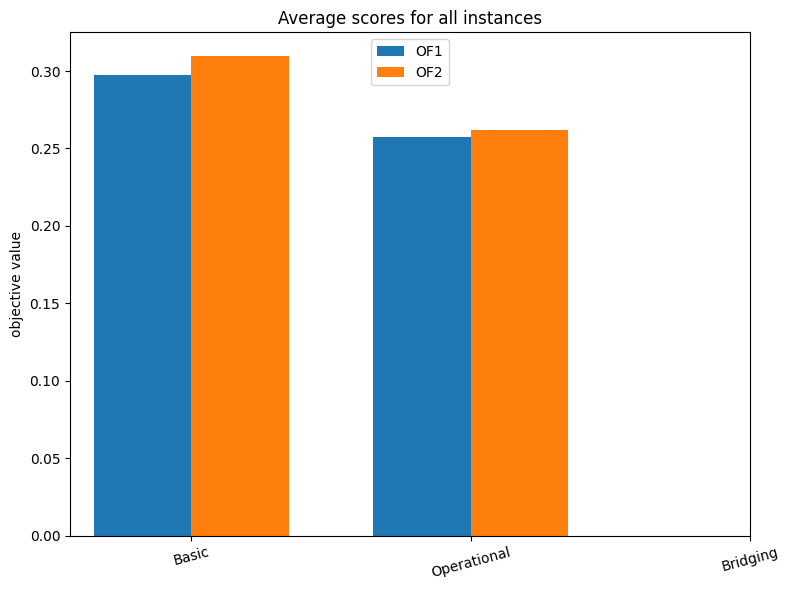

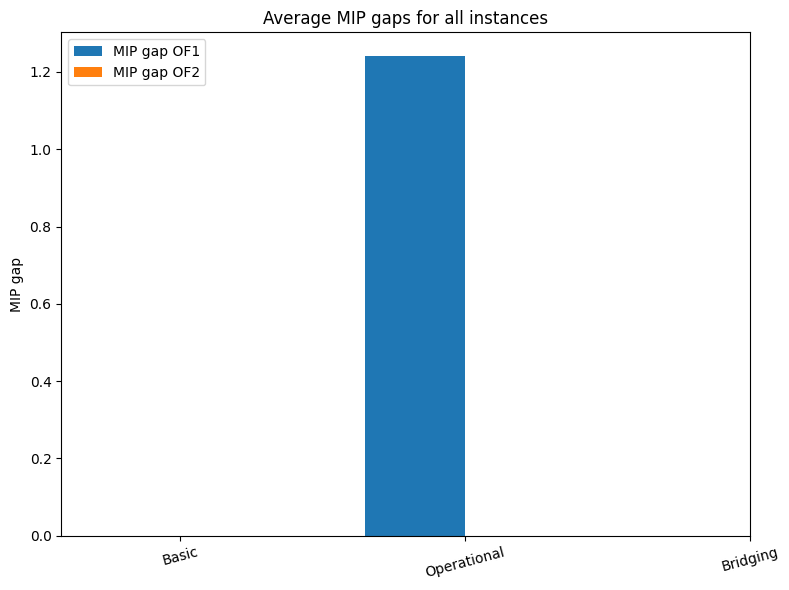

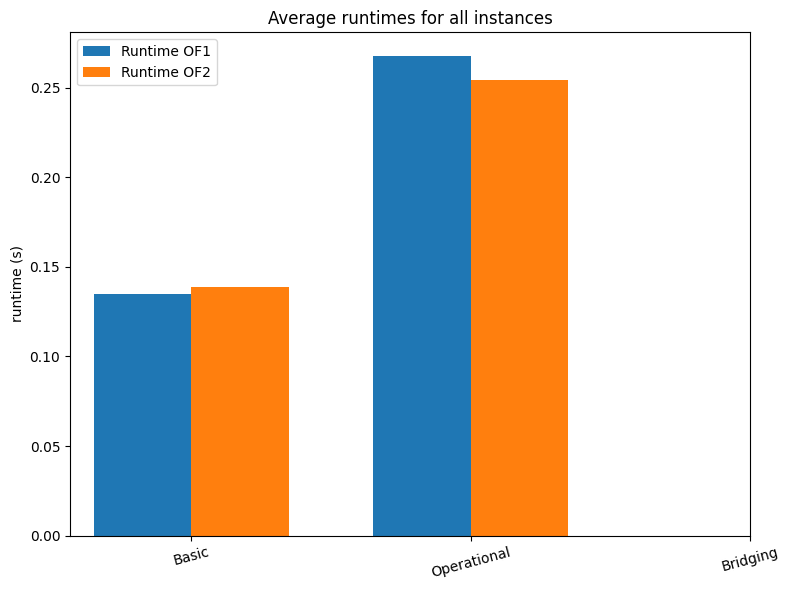

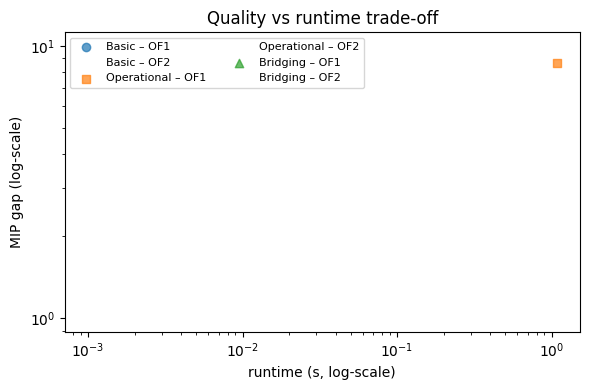

In [ ]:
# ------------------------------------------------------------
# 1) Turn the raw list of dicts into a tidy DataFrame
# ------------------------------------------------------------
df = pd.DataFrame(records)
models_order = ["Basic", "Operational", "Bridging"]  # desired order on X-axis
df["model"] = pd.Categorical(df["model"], categories=models_order, ordered=True)

# ------------------------------------------------------------
# 2) Objective function plots
# ------------------------------------------------------------
objective_functions_path = "plots/objective_functions"
# 2.1) A bar chart for each instance 
for inst, sub in df.groupby("instance", sort=False):
    fig, ax = plt.subplots(figsize=(6, 4))

    # bar positions – two bars per model
    x_base = np.arange(len(models_order))
    width   = 0.35                      # width of a single bar
    bar1_x  = x_base - width/2          # OF1 bars (left)
    bar2_x  = x_base + width/2          # OF2 bars (right)

    # heights for the bars
    of1_vals = sub.set_index("model")["OF1"].reindex(models_order) / sub["OF1"].max()  # normalize to max value for better visibility
    of2_vals = sub.set_index("model")["OF2"].reindex(models_order) / sub["OF2"].max()  # normalize to max value for better visibility

    ax.bar(bar1_x, of1_vals, width, label="OF1")
    ax.bar(bar2_x, of2_vals, width, label="OF2")

    # cosmetics -----------------------------------------------------
    ax.set_title(f"Scores for instance {inst}")
    ax.set_xticks(x_base)
    ax.set_xticklabels(models_order, rotation=15)
    ax.set_ylabel("objective value")
    ax.legend()

    plt.tight_layout()
    # Save the figure
    plt.savefig(f"{objective_functions_path}/{inst}.png", dpi=150, bbox_inches="tight")
    plt.close(fig)  

# 2.2) A bar chart for the average scores
fig, ax = plt.subplots(figsize=(8, 6))

# bar positions – two bars per model
x_base = np.arange(len(models_order))
width   = 0.35                      # width of a single bar
bar1_x  = x_base - width/2          # OF1 bars (left)
bar2_x  = x_base + width/2          # OF2 bars (right)

# heights for the bars
of1_vals = df.groupby("model", observed=True)["OF1"].mean().reindex(models_order) / df["OF1"].max()  # normalize to max value for better visibility
of2_vals = df.groupby("model", observed=True)["OF2"].mean().reindex(models_order) / df["OF2"].max()  # normalize to max value for better visibility
ax.bar(bar1_x, of1_vals, width, label="OF1")
ax.bar(bar2_x, of2_vals, width, label="OF2")

# cosmetics -----------------------------------------------------
ax.set_title("Average scores for all instances")
ax.set_xticks(x_base)
ax.set_xticklabels(models_order, rotation=15)
ax.set_ylabel("objective value")
ax.legend()

plt.tight_layout()
# Save the figure
plt.savefig(f"{objective_functions_path}/average_scores.png", dpi=150, bbox_inches="tight")
plt.show()

# ------------------------------------------------------------
# 4) MIP gaps plots
# ------------------------------------------------------------
mip_gaps_path = "plots/mip_gaps"

# 4.1) A bar chart for each instance
for inst, sub in df.groupby("instance", sort=False):
    fig, ax = plt.subplots(figsize=(6, 4))

    # bar positions – two bars per model
    x_base = np.arange(len(models_order))
    width   = 0.35                      # width of a single bar
    bar1_x  = x_base - width/2          # MIP gap OF1 bars (left)
    bar2_x  = x_base + width/2          # MIP gap OF2 bars (right)

    # heights for the bars
    mipgap1_vals = sub.set_index("model")["MIPgap_1"].reindex(models_order)
    mipgap2_vals = sub.set_index("model")["MIPgap_2"].reindex(models_order)

    ax.bar(bar1_x, mipgap1_vals, width, label="MIP gap OF1")
    ax.bar(bar2_x, mipgap2_vals, width, label="MIP gap OF2")

    # cosmetics -----------------------------------------------------
    ax.set_title(f"MIP gaps for instance {inst}")
    ax.set_xticks(x_base)
    ax.set_xticklabels(models_order, rotation=15)
    ax.set_ylabel("MIP gap")
    ax.legend()

    plt.tight_layout()
    # Save the figure
    plt.savefig(f"{mip_gaps_path}/mip_gap_{inst}.png", dpi=150, bbox_inches="tight")
    plt.close(fig)

# 4.2) A bar chart for the average MIP gaps 

fig, ax = plt.subplots(figsize=(8, 6))

# bar positions – two bars per model
x_base = np.arange(len(models_order))
width   = 0.35                      # width of a single bar
bar1_x  = x_base - width/2          # MIP gap OF1 bars (left)
bar2_x  = x_base + width/2          # MIP gap OF2 bars (right)

# heights for the bars
mipgap1_vals = df.groupby("model", observed=True)["MIPgap_1"].mean().reindex(models_order)
mipgap2_vals = df.groupby("model", observed=True)["MIPgap_2"].mean().reindex(models_order)
ax.bar(bar1_x, mipgap1_vals, width, label="MIP gap OF1")
ax.bar(bar2_x, mipgap2_vals, width, label="MIP gap OF2")

# cosmetics -----------------------------------------------------
ax.set_title("Average MIP gaps for all instances")
ax.set_xticks(x_base)
ax.set_xticklabels(models_order, rotation=15)
ax.set_ylabel("MIP gap")
ax.legend()

plt.tight_layout()
# Save the figure
plt.savefig(f"{mip_gaps_path}/average_mip_gaps.png", dpi=150, bbox_inches="tight")
plt.show()

# ------------------------------------------------------------
# 5) Runtime plots
# ------------------------------------------------------------
runtime_path = "plots/runtime"

# 5.1) A bar chart for each instance
for inst, sub in df.groupby("instance", sort=False):
    fig, ax = plt.subplots(figsize=(6, 4))

    # bar positions – two bars per model
    x_base = np.arange(len(models_order))
    width   = 0.35                      # width of a single bar
    bar1_x  = x_base - width/2          # runtime OF1 bars (left)
    bar2_x  = x_base + width/2          # runtime OF2 bars (right)

    # heights for the bars
    rt1_vals = sub.set_index("model")["runtime_1"].reindex(models_order)
    rt2_vals = sub.set_index("model")["runtime_2"].reindex(models_order)

    ax.bar(bar1_x, rt1_vals, width, label="Runtime OF1")
    ax.bar(bar2_x, rt2_vals, width, label="Runtime OF2")

    # cosmetics -----------------------------------------------------
    ax.set_title(f"Runtimes for instance {inst}")
    ax.set_xticks(x_base)
    ax.set_xticklabels(models_order, rotation=15)
    ax.set_ylabel("runtime (s)")
    ax.legend()

    plt.tight_layout()
    # Save the figure
    plt.savefig(f"{runtime_path}/runtime_{inst}.png", dpi=150, bbox_inches="tight")
    plt.close(fig)

# 5.2) A bar chart for the average runtimes
fig, ax = plt.subplots(figsize=(8, 6))

# bar positions – two bars per model
x_base = np.arange(len(models_order))
width   = 0.35                      # width of a single bar
bar1_x  = x_base - width/2          # runtime OF1 bars (left)
bar2_x  = x_base + width/2          # runtime OF2 bars (right)
# heights for the bars
rt1_vals = df.groupby("model", observed=True)["runtime_1"].mean().reindex(models_order)
rt2_vals = df.groupby("model", observed=True)["runtime_2"].mean().reindex(models_order)
ax.bar(bar1_x, rt1_vals, width, label="Runtime OF1")
ax.bar(bar2_x, rt2_vals, width, label="Runtime OF2")
# cosmetics -----------------------------------------------------
ax.set_title("Average runtimes for all instances")
ax.set_xticks(x_base)
ax.set_xticklabels(models_order, rotation=15)
ax.set_ylabel("runtime (s)")
ax.legend()
plt.tight_layout()
# Save the figure
plt.savefig(f"{runtime_path}/average_runtime.png", dpi=150, bbox_inches="tight")
plt.show()


# ------------------------------------------------------------
# 6) Quality vs runtime trade-off plot
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6,4))
markers = {"Basic":"o", "Operational":"s", "Bridging":"^"}

for m in models_order:
    sub = df[df["model"] == m]
    ax.scatter(sub["runtime_1"], sub["MIPgap_1"],
               marker=markers[m], label=f"{m} – OF1", alpha=.7)
    ax.scatter(sub["runtime_2"], sub["MIPgap_2"],
               marker=markers[m], label=f"{m} – OF2", facecolors='none', alpha=.7)

ax.set_xscale("log");  ax.set_yscale("log")
ax.set_xlabel("runtime (s, log-scale)")
ax.set_ylabel("MIP gap (log-scale)")
ax.set_title("Quality vs runtime trade-off")
ax.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.savefig("plots/quality_vs_runtime.png", dpi=150, bbox_inches="tight")
plt.show()
